In [422]:
%matplotlib inline

In [423]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import simpy

In [424]:
# Global variables
# Copied from the MDP code

# Queue size
MAX_QUEUE_SIZE = 20

# Arrival average of customers per unit time (Poisson process)
ARRIVAL_SIMPLE = 10
ARRIVAL_COMPLEX = 5

# Service rate of agents for each query types (Exponential distribution)
## Agent 1
SERVICE_SIMPLE_1 = 14
SERVICE_COMPLEX_1 = 3
## Agent 2
SERVICE_SIMPLE_2 = 7
SERVICE_COMPLEX_2 = 6

In [425]:
# Data collection lists
waiting_times = []
agent_utilisations = {'Agent 1 Simple': 0,
                      'Agent 1 Complex': 0,
                      'Agent 2 Simple': 0,
                      'Agent 2 Complex': 0,
                      'Dropped Calls': 0}
queue_lengths = []
queue_length_times = []

In [426]:
def get_policy_decision(policy_simple, policy_complex, q1, q2, call_type):
    """
    Get the policy decision based on the current state.
    returns the action to take (0 to agent1 or 1 to agent2).
    """
    
    # Ensure we don't exceed the maximum queue size
    q1 = min(q1, MAX_QUEUE_SIZE)
    q2 = min(q2, MAX_QUEUE_SIZE)
    
    if call_type == 'Simple':
        return policy_simple[q1, q2]
    else:
        return policy_complex[q1, q2]


def handle_call(env, policy_simple, policy_complex, call_type, agent1, agent2):
    """Handle the call from arrival to completion."""
    arrival_time = env.now
    
    # Get current queue sizes
    q1 = len(agent1.queue) + (1 if agent1.count > 0 else 0)
    q2 = len(agent2.queue) + (1 if agent2.count > 0 else 0)
    
    # Check if queues are full
    q1_full = q1 >= MAX_QUEUE_SIZE
    q2_full = q2 >= MAX_QUEUE_SIZE
    
    decision = get_policy_decision(policy_simple, policy_complex, q1, q2, call_type)
    
    # Route to selected queue if not full
    if decision == 0 and not q1_full:
        queue = agent1
    elif decision == 1 and not q2_full:
        queue = agent2
    elif not q1_full:
        queue = agent1
        decision = 0
    elif not q2_full:
        queue = agent2
        decision = 1
    else:
        # Both queues are full, drop the call
        agent_utilisations['Dropped Calls'] += 1
        print(f'{call_type} call dropped at {env.now}')
        return
    
    # Get into the queue and request service
    with queue.request() as req:
        yield req
        
        # Call is being served
        service_start_time = env.now
        waiting_time = service_start_time - arrival_time
        
        # Determine service time based on agent and call type
        if decision == 0:
            service_rate = SERVICE_SIMPLE_1 if call_type == 'Simple' else SERVICE_COMPLEX_1
        else:
            service_rate = SERVICE_SIMPLE_2 if call_type == 'Simple' else SERVICE_COMPLEX_2
            
        service_time = random.expovariate(service_rate)
        
        # Serve the call
        yield env.timeout(service_time)
        
        # Call completed
        completion_time = env.now
        total_time = completion_time - arrival_time
        
        # Record statistics
        waiting_times.append({
            'call_type': call_type,
            'queue': decision + 1,
            'arrival_time': arrival_time,
            'waiting_time': waiting_time,
            'service_time': service_time,
            'total_time': total_time
        })
        
        # Update agent utilisation
        agent_utilisations[f'Agent {decision + 1} {call_type}'] += 1

def simple_call_generator(env, policy_simple, policy_complex, queue1, queue2):
    """Generate simple calls according to a Poisson process."""
    while True:
        interarrival_time = random.expovariate(ARRIVAL_SIMPLE)
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_simple, policy_complex, 'Simple', queue1, queue2))
        
def complex_call_generator(env, policy_simple, policy_complex, queue1, queue2):
    """Generate complex calls according to a Poisson process."""
    while True:
        interarrival_time = random.expovariate(ARRIVAL_COMPLEX)
        yield env.timeout(interarrival_time)
        
        # Create a new call
        env.process(handle_call(env, policy_simple, policy_complex, 'Complex', queue1, queue2))
        
def record_queue_length(env, queue1, queue2):
    """Record the lengths of the queues at regular intervals."""
    while True:
        # Queue length includes the customer being served
        queue1_len = len(queue1.queue) + (1 if queue1.count > 0 else 0)
        queue2_len = len(queue2.queue) + (1 if queue2.count > 0 else 0)
        
        queue_lengths.append((
            queue1_len,
            queue2_len,
            env.now
        ))
        queue_length_times.append(env.now)
        
        yield env.timeout(0.1)

In [427]:
# Get results from the simulation
def get_results():
    """Compute and return the results of the simulation."""
    # Convert waiting times to DataFrame
    df_waiting = pd.DataFrame(waiting_times)
    
    # Calculate average metrics
    avg_waiting_time = df_waiting['waiting_time'].mean() if not df_waiting.empty else 0
    avg_service_time = df_waiting['service_time'].mean() if not df_waiting.empty else 0
    avg_total_time = df_waiting['total_time'].mean() if not df_waiting.empty else 0
    
    # Calculate metrics by call type
    avg_waiting_by_type = df_waiting.groupby('call_type')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    avg_service_by_type = df_waiting.groupby('call_type')['service_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Calculate metrics by queue
    avg_waiting_by_queue = df_waiting.groupby('queue')['waiting_time'].mean().to_dict() if not df_waiting.empty else {}
    
    # Extract queue lengths and times
    queue_data = pd.DataFrame(queue_lengths, columns=['Queue 1 Length', 'Queue 2 Length', 'Time'])
    avg_queue_length = [queue_data['Queue 1 Length'].mean(), queue_data['Queue 2 Length'].mean()]
    
    # Calculate call volumes
    completed_calls = agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 1 Complex'] + \
                    agent_utilisations['Agent 2 Simple'] + agent_utilisations['Agent 2 Complex']
    total_calls = completed_calls + agent_utilisations['Dropped Calls']
    
    call_counts = {
        'total': total_calls,
        'completed': completed_calls,
        'simple': agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 2 Simple'],
        'complex': agent_utilisations['Agent 1 Complex'] + agent_utilisations['Agent 2 Complex'],
        'agent1': agent_utilisations['Agent 1 Simple'] + agent_utilisations['Agent 1 Complex'],
        'agent2': agent_utilisations['Agent 2 Simple'] + agent_utilisations['Agent 2 Complex'],
        'dropped': agent_utilisations['Dropped Calls'],
        'drop_rate': agent_utilisations['Dropped Calls'] / total_calls if total_calls > 0 else 0
        }
    
    # Combine all results into a dictionary
    results = {
        'call_counts': call_counts,
        'avg_waiting_time': avg_waiting_time,
        'avg_service_time': avg_service_time,
        'avg_total_time': avg_total_time,
        'avg_waiting_by_type': avg_waiting_by_type,
        'avg_service_by_type': avg_service_by_type,
        'avg_waiting_by_queue': avg_waiting_by_queue,
        'avg_queue_length': avg_queue_length,
        'waiting_times_df': df_waiting,
        'queue_data': queue_data
    }
    
    return results
    

# Run the simulation
def run_simulation(policy_simple, policy_complex, sim_time=1000):
    """Run the simulation for a given time."""
    env = simpy.Environment()
    
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Reset global variables
    global waiting_times, agent_utilisations, queue_lengths, queue_length_times
    waiting_times = []
    agent_utilisations = {'Agent 1 Simple': 0,
                            'Agent 1 Complex': 0,
                            'Agent 2 Simple': 0,
                            'Agent 2 Complex': 0,
                            'Dropped Calls': 0}
    queue_lengths = []
    queue_length_times = []
    
    agent1 = simpy.Resource(env, capacity=1)
    agent2 = simpy.Resource(env, capacity=1)
    
    # Start call generators
    env.process(simple_call_generator(env, policy_simple, policy_complex, agent1, agent2))
    env.process(complex_call_generator(env, policy_simple, policy_complex, agent1, agent2))
    
    # Start queue length recorder
    env.process(record_queue_length(env, agent1, agent2))
    
    # Run the simulation
    env.run(until=sim_time)
    
    # Get results
    results = get_results()
    return results
    
# Plotting functions

def plot_policies(policy_simple, policy_complex):
    """Plot the policies for simple and complex calls."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sns.heatmap(policy_simple, cmap="YlGnBu", annot=True, fmt=".0f", cbar=False, ax=axes[0])
    axes[0].set_title('Policy for Simple Calls')
    axes[0].set_xlabel('Queue 2 Size')
    axes[0].set_ylabel('Queue 1 Size')
    
    sns.heatmap(policy_complex, cmap="YlOrBr", annot=True, fmt=".0f", cbar=False, ax=axes[1])
    axes[1].set_title('Policy for Complex Calls')
    axes[1].set_xlabel('Queue 2 Size')
    axes[1].set_ylabel('Queue 1 Size')
    
    plt.tight_layout()
    plt.show()
    
def plot_queue_length_over_time(results):
    """Plot the queue lengths over time."""
    queue_data = results['queue_data']
    
    plt.figure(figsize=(12, 6))
    plt.plot(queue_data['Time'], queue_data['Queue 1 Length'], label='Queue 1 Length', color='blue')
    plt.plot(queue_data['Time'], queue_data['Queue 2 Length'], label='Queue 2 Length', color='orange')
    
    plt.title('Queue Lengths Over Time')
    plt.xlabel('Time')
    plt.ylabel('Queue Length')
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_waiting_times_by_queue(results):
    """Plot the average waiting times by queue."""
    df_waiting = results['waiting_times_df']
    
    plt.figure(figsize=(8, 5))
    sns.barplot(data=df_waiting, x='queue', y='waiting_time')
    
    plt.title('Average Waiting Time by Queue')
    plt.xlabel('Queue')
    plt.ylabel('Average Waiting Time')
    plt.grid()
    plt.show()

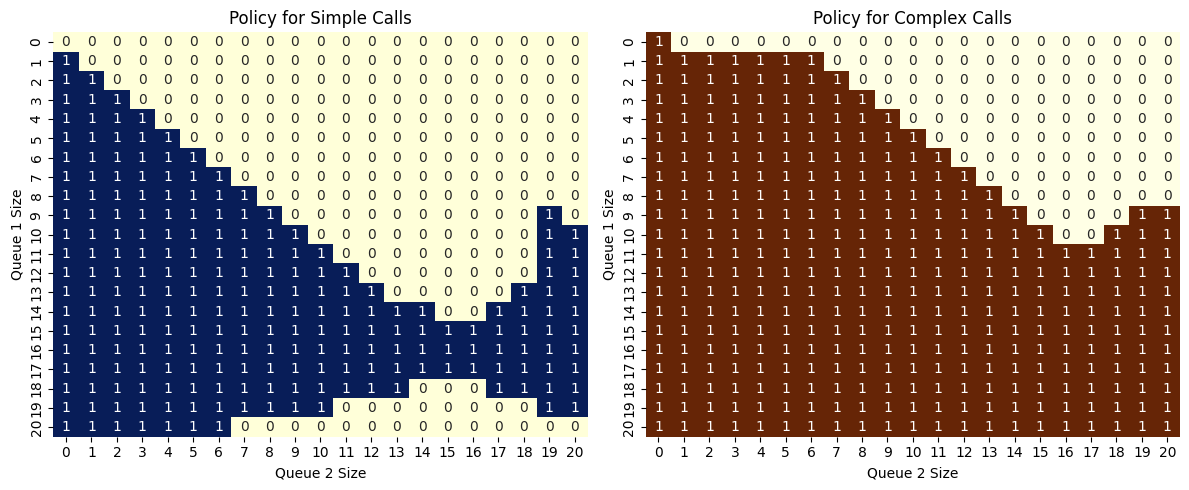

In [428]:
# Load optimal policy from the pickle file
with open('policy_simple.pkl', 'rb') as f:
    opt_simple_policy = pickle.load(f)
with open('policy_complex.pkl', 'rb') as f:
    opt_complex_policy = pickle.load(f)

# Set runtime for the simulation
RUNTIME = 24  # Simulate for 24 hours

# Plot the policies
plot_policies(opt_simple_policy, opt_complex_policy)

In [429]:
# Run the simulation
results = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=RUNTIME)


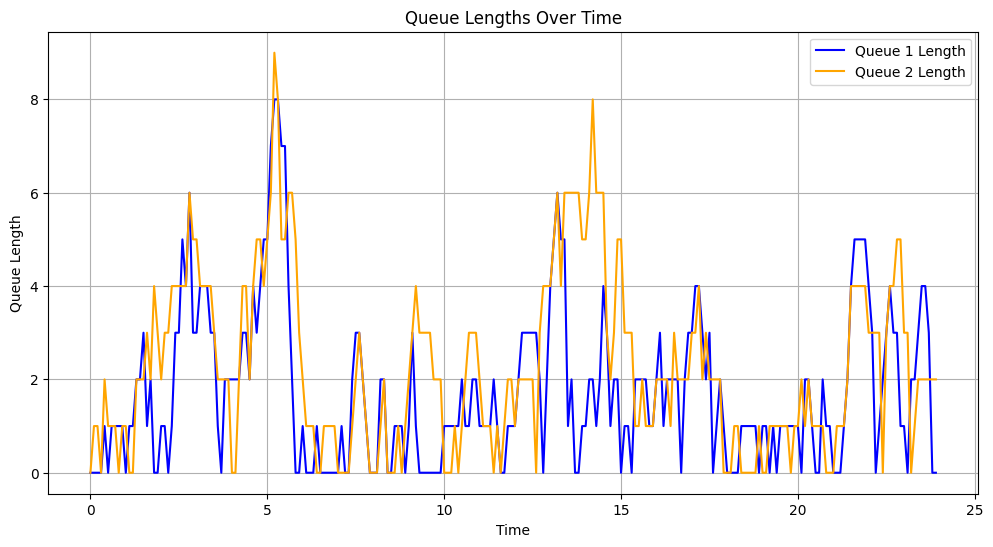

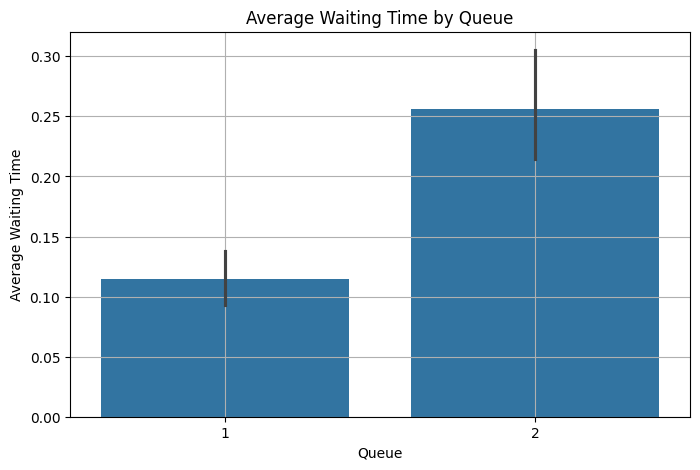

In [430]:
# Plot the results

plot_queue_length_over_time(results)
plot_waiting_times_by_queue(results)

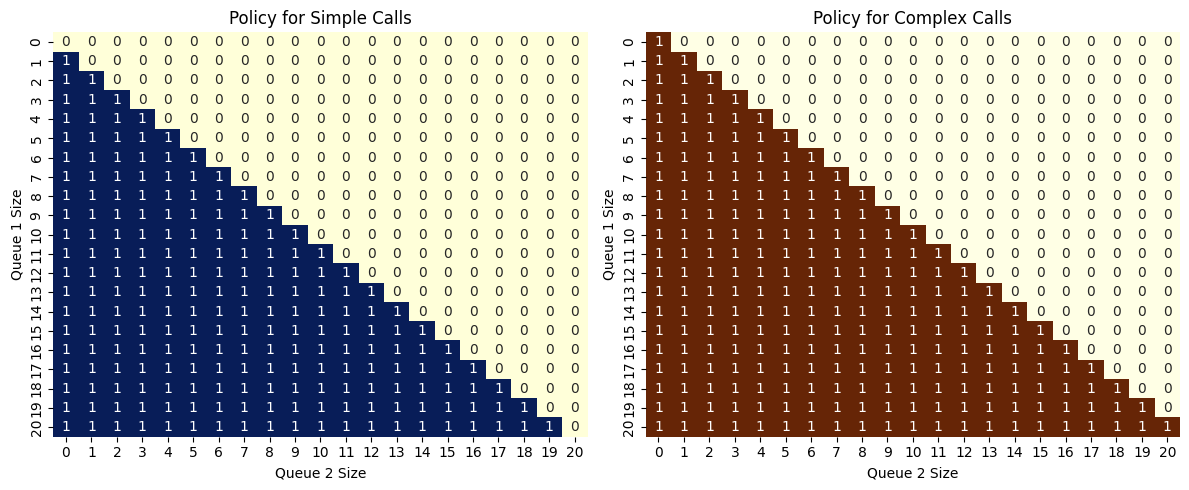

In [431]:
# Create another policy for comparison
# Route calls to the queue with the least number of calls
# If both queues size are equal, route simple calls to queue 1 and complex calls to queue 2
alt_simple_policy = np.zeros((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_simple_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_simple_policy[i, j] = 1  # Route to queue 2
            
alt_complex_policy = np.ones((MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1), dtype=int)
for i in range(MAX_QUEUE_SIZE + 1):
    for j in range(MAX_QUEUE_SIZE + 1):
        if i < j:
            alt_complex_policy[i, j] = 0  # Route to queue 1
        elif i > j:
            alt_complex_policy[i, j] = 1  # Route to queue 2
            
# Plot the new policies
plot_policies(alt_simple_policy, alt_complex_policy)

In [432]:
# Run the simulation
results_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=RUNTIME)


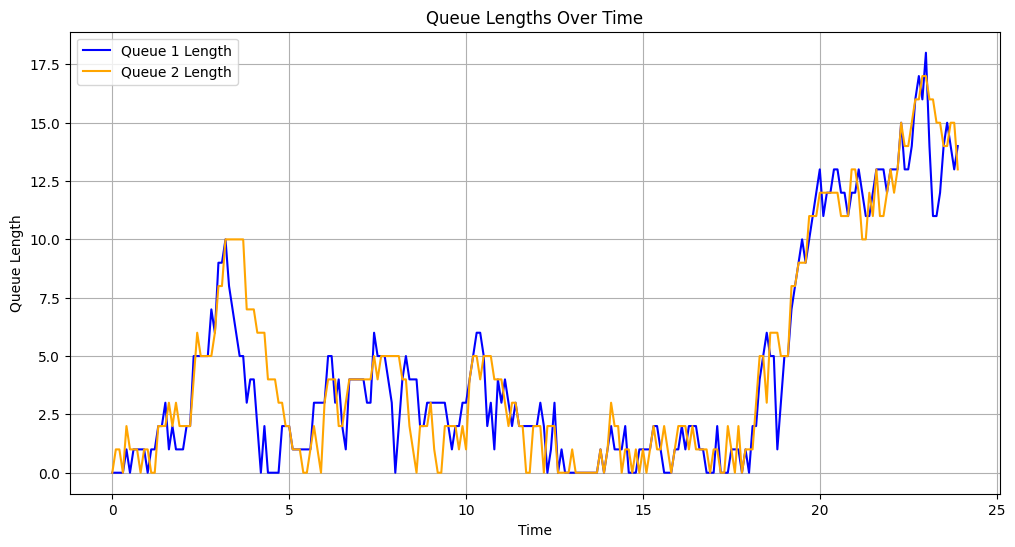

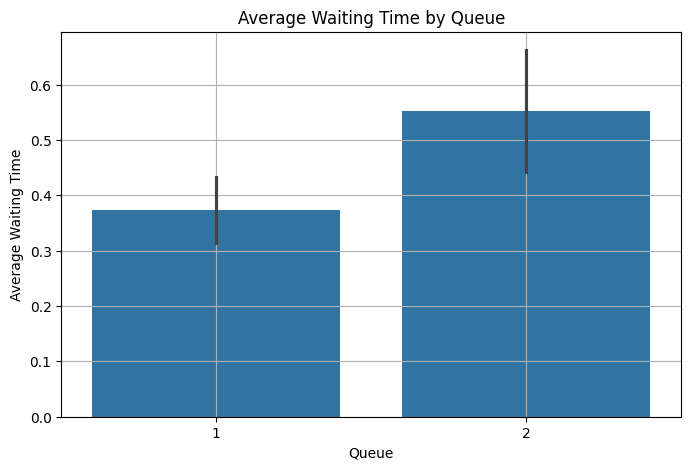

In [433]:
# Plot the results

plot_queue_length_over_time(results_2)
plot_waiting_times_by_queue(results_2)

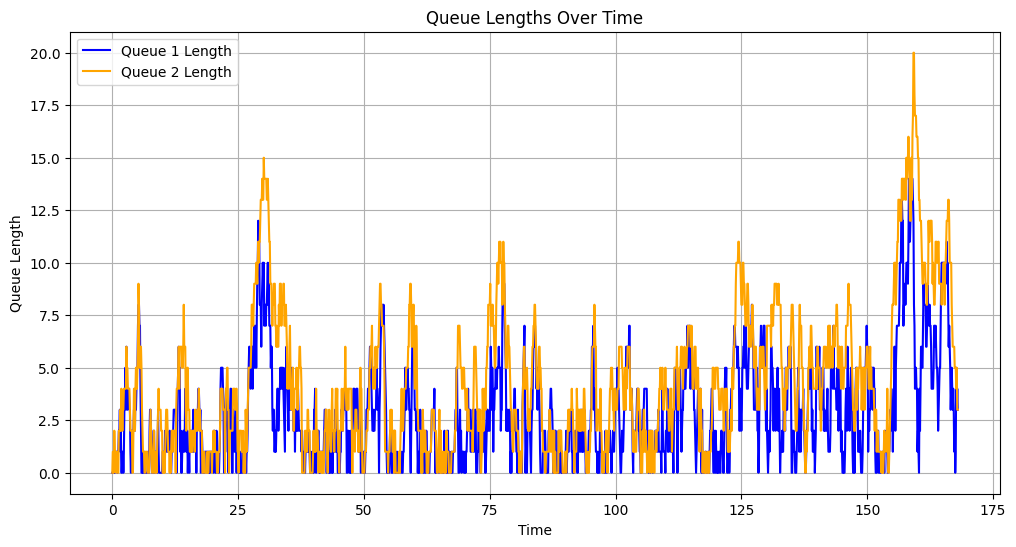

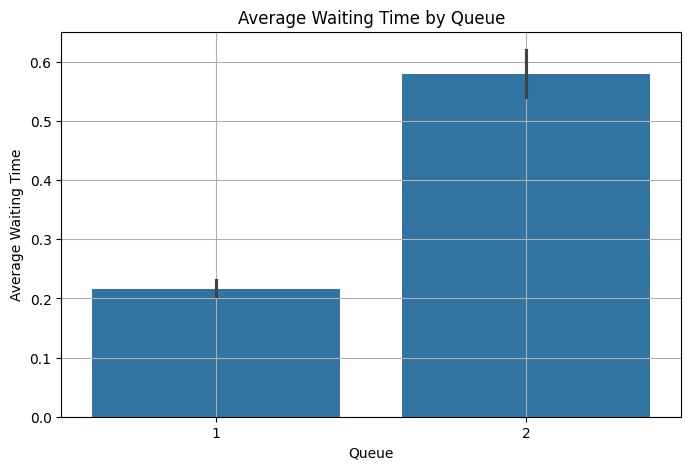

In [434]:
# Simulate for a week (168 hours)

results_week = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=168)
# Plot the results for the week
plot_queue_length_over_time(results_week)
plot_waiting_times_by_queue(results_week)

Complex call dropped at 31.456293125255073
Simple call dropped at 31.643807915730914
Complex call dropped at 31.905607208901618
Simple call dropped at 31.91025442922522
Complex call dropped at 56.43685135549898
Complex call dropped at 56.55019595263528
Complex call dropped at 57.251147942395676
Simple call dropped at 107.53594405094236
Simple call dropped at 109.29401772685853
Complex call dropped at 109.30266539472333
Simple call dropped at 113.86121369703154
Complex call dropped at 113.98947426272638
Complex call dropped at 114.89982139144698
Complex call dropped at 115.05280808210114
Simple call dropped at 115.38205956267845
Simple call dropped at 115.40204327182181
Simple call dropped at 115.41231335116447
Simple call dropped at 115.4260035308788
Simple call dropped at 115.45593202355124
Simple call dropped at 115.64135725892517
Complex call dropped at 115.6939706130633
Simple call dropped at 115.75521084301913
Simple call dropped at 115.7645649979167
Complex call dropped at 115.77

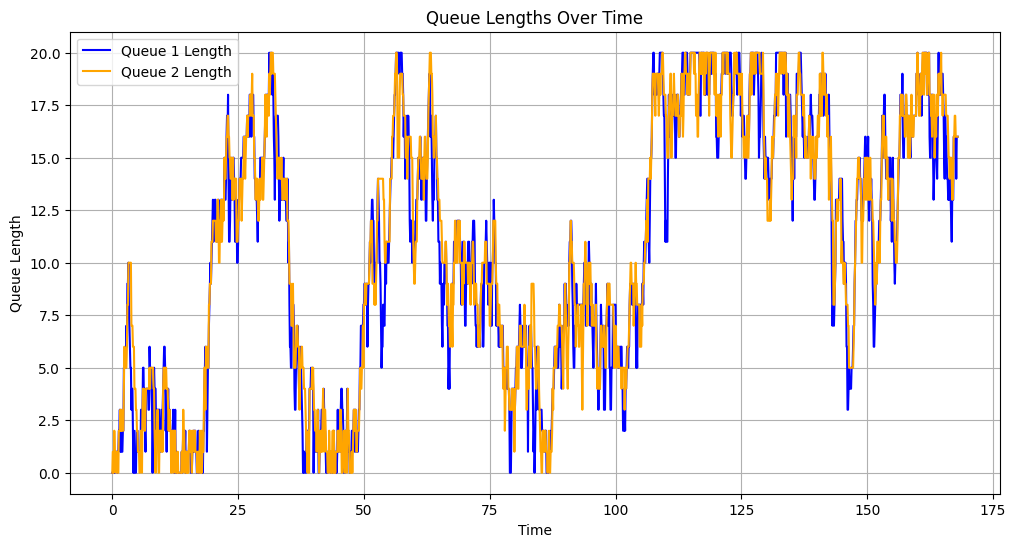

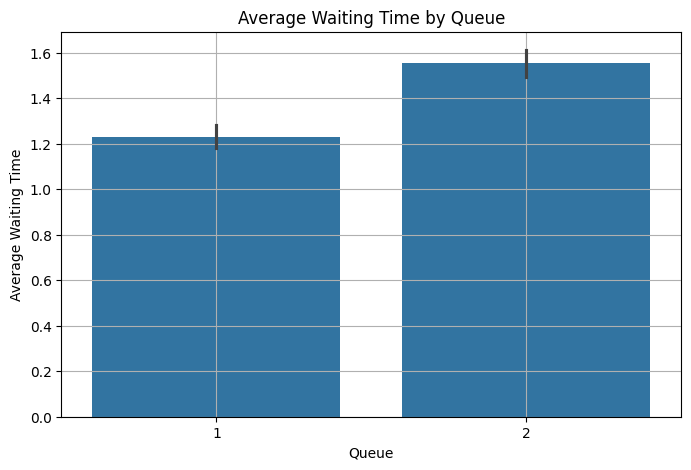

In [435]:
results_week_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=168)
# Plot the results for the week
plot_queue_length_over_time(results_week_2)
plot_waiting_times_by_queue(results_week_2)

Simple call dropped at 276.33133574229544
Simple call dropped at 276.5200647520598
Simple call dropped at 276.56122466247353
Complex call dropped at 276.6434802133391
Simple call dropped at 276.6745135768473
Complex call dropped at 278.91353281765436
Simple call dropped at 279.01108311625177
Simple call dropped at 279.11852939659775
Complex call dropped at 279.3249190935935
Simple call dropped at 279.373987094428
Complex call dropped at 279.3892954246124
Simple call dropped at 279.4798864927368
Complex call dropped at 279.4808544934254
Simple call dropped at 279.4926698737079
Complex call dropped at 279.4981048971686
Simple call dropped at 280.6649375038317
Simple call dropped at 280.78739389478636
Complex call dropped at 280.9306449672022
Simple call dropped at 282.9151437722126
Simple call dropped at 282.9318072651908
Complex call dropped at 282.9971041909955
Simple call dropped at 287.21663307641103
Complex call dropped at 287.9261785118268
Simple call dropped at 291.32995881739714


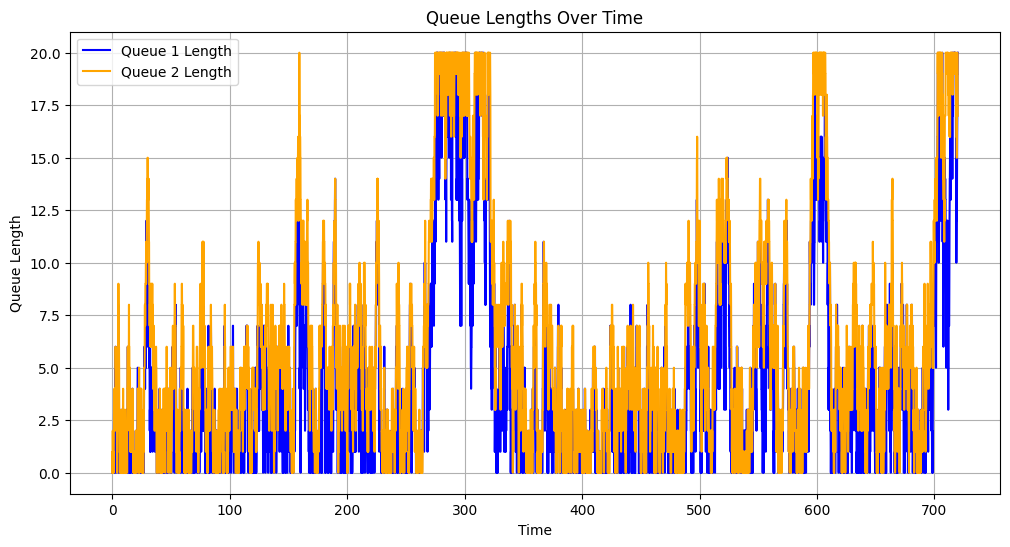

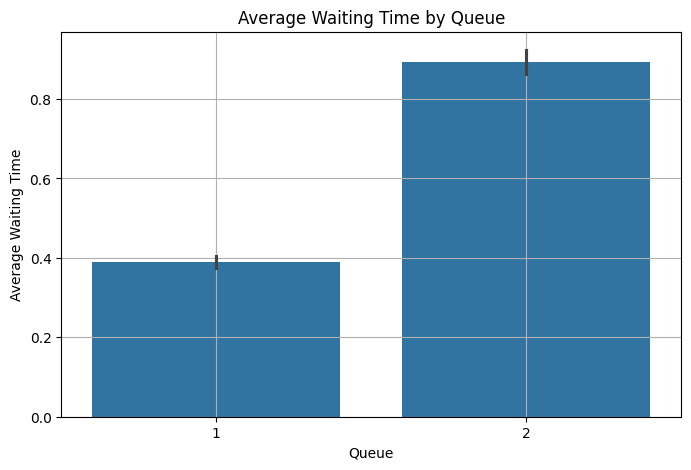

In [436]:
# Simulate for a month (720 hours)
results_month = run_simulation(opt_simple_policy, opt_complex_policy, sim_time=720)
# Plot the results for the month
plot_queue_length_over_time(results_month)
plot_waiting_times_by_queue(results_month)

Complex call dropped at 31.456293125255073
Simple call dropped at 31.643807915730914
Complex call dropped at 31.905607208901618
Simple call dropped at 31.91025442922522
Complex call dropped at 56.43685135549898
Complex call dropped at 56.55019595263528
Complex call dropped at 57.251147942395676
Simple call dropped at 107.53594405094236
Simple call dropped at 109.29401772685853
Complex call dropped at 109.30266539472333
Simple call dropped at 113.86121369703154
Complex call dropped at 113.98947426272638
Complex call dropped at 114.89982139144698
Complex call dropped at 115.05280808210114
Simple call dropped at 115.38205956267845
Simple call dropped at 115.40204327182181
Simple call dropped at 115.41231335116447
Simple call dropped at 115.4260035308788
Simple call dropped at 115.45593202355124
Simple call dropped at 115.64135725892517
Complex call dropped at 115.6939706130633
Simple call dropped at 115.75521084301913
Simple call dropped at 115.7645649979167
Complex call dropped at 115.77

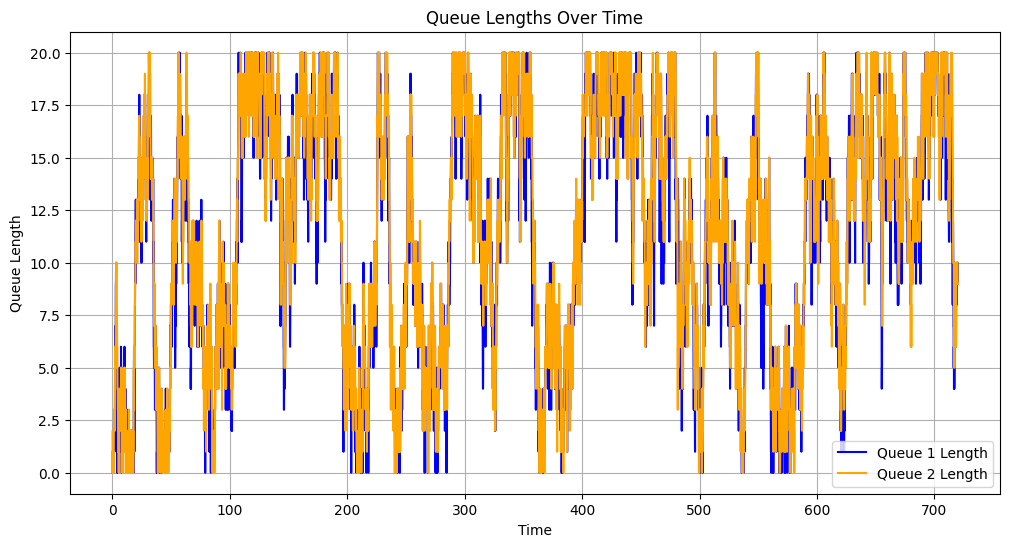

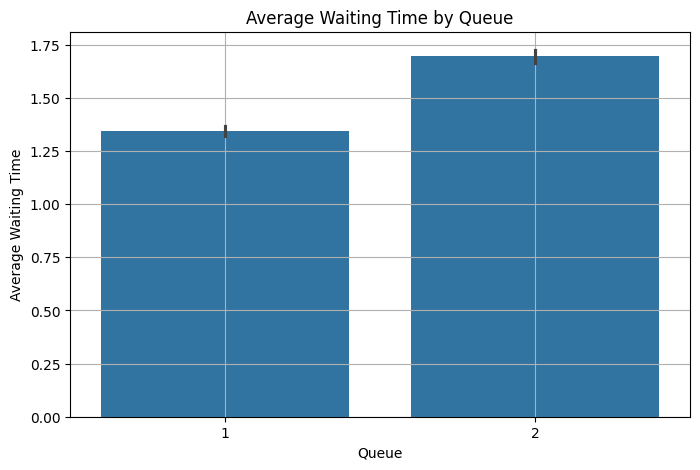

In [437]:
results_month_2 = run_simulation(alt_simple_policy, alt_complex_policy, sim_time=720)
# Plot the results for the month
plot_queue_length_over_time(results_month_2)
plot_waiting_times_by_queue(results_month_2)

In [438]:
def metrics_df(results_1, results_2):
    """Create a metrics comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Average Waiting Time', 'Average Service Time', 'Average Total Time',
                'Average Queue Length 1', 'Average Queue Length 2'],
        'Optimal Policy': [results['avg_waiting_time'], results['avg_service_time'], results['avg_total_time'],
                        results['avg_queue_length'][0], results['avg_queue_length'][1]],
        'Generated Policy': [results_2['avg_waiting_time'], results_2['avg_service_time'], results_2['avg_total_time'],
                    results_2['avg_queue_length'][0], results_2['avg_queue_length'][1]]
    })
    df.set_index('Metric', inplace=True)
    df['Improvement'] = df['Optimal Policy'] - df['Generated Policy']
    
    return df

In [439]:
# Compare metrics between the two policies with different runtimes
day_df = metrics_df(results, results_2)
week_df = metrics_df(results_week, results_week_2)
month_df = metrics_df(results_month, results_month_2)

# Display the comparison
print("\nComparison of Metrics Between Policies (One Day):")
print(day_df)
print("\nComparison of Metrics Between Policies (One Week):")
print(week_df)
print("\nComparison of Metrics Between Policies (One Month):")
print(month_df)


Comparison of Metrics Between Policies (One Day):
                        Optimal Policy  Generated Policy  Improvement
Metric                                                               
Average Waiting Time          0.171299          0.444529    -0.273230
Average Service Time          0.109556          0.124847    -0.015290
Average Total Time            0.280855          0.569376    -0.288520
Average Queue Length 1        1.725000          4.345833    -2.620833
Average Queue Length 2        2.279167          4.600000    -2.320833

Comparison of Metrics Between Policies (One Week):
                        Optimal Policy  Generated Policy  Improvement
Metric                                                               
Average Waiting Time          0.171299          1.373967    -1.202669
Average Service Time          0.109556          0.136645    -0.027088
Average Total Time            0.280855          1.510612    -1.229757
Average Queue Length 1        1.725000         10.664485 

In [444]:
def volume_df(results_1, results_2):
    """Create a volume comparison DataFrame for two sets of results."""
    df = pd.DataFrame({
        'Metric': ['Total Calls', 'Completed Calls',
                'Agent 1 Calls', 'Agent 2 Calls', 'Dropped Calls'],
        'Optimal Policy': [results_1['call_counts']['total'], results_1['call_counts']['completed'],
                        results_1['call_counts']['agent1'], results_1['call_counts']['agent2'],
                        results_1['call_counts']['dropped']],
        'Generated Policy': [results_2['call_counts']['total'], results_2['call_counts']['completed'],
                            results_2['call_counts']['agent1'], results_2['call_counts']['agent2'],
                            results_2['call_counts']['dropped']]
    })
    df.set_index('Metric', inplace=True)
    df['Improvement'] = df['Optimal Policy'] - df['Generated Policy']
    
    return df

In [445]:
# Compare call volumes between the two policies
call_volume_day = volume_df(results, results_2)
call_volume_week = volume_df(results_week, results_week_2)
call_volume_month = volume_df(results_month, results_month_2)

# Display the call volume comparison
print("\nComparison of Call Volumes Between Policies (One Day):")
print(call_volume_day)
print("\nComparison of Call Volumes Between Policies (One Week):")
print(call_volume_week)
print("\nComparison of Call Volumes Between Policies (One Month):")
print(call_volume_month)


Comparison of Call Volumes Between Policies (One Day):
                 Optimal Policy  Generated Policy  Improvement
Metric                                                        
Total Calls                 338               325           13
Completed Calls             338               325           13
Agent 1 Calls               203               197            6
Agent 2 Calls               135               128            7
Dropped Calls                 0                 0            0

Comparison of Call Volumes Between Policies (One Week):
                 Optimal Policy  Generated Policy  Improvement
Metric                                                        
Total Calls                2478              2454           24
Completed Calls            2478              2370          108
Agent 1 Calls              1509              1316          193
Agent 2 Calls               969              1054          -85
Dropped Calls                 0                84          -84

Comp